# GEMdataset

> This package will hold the GxExM dataset.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *
#| hide
from hybridpredictmaize22.core import *

In [ ]:
#| export
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

from tqdm import tqdm

In [ ]:
def collect_snps(method):
    """
    Input
        method: a Path(PosixPath) to directory containing npy arrays for each chr
    Output
        tuple(hybrid ids, snp matrix)
    """
    for c,chr in enumerate(method.iterdir()):
        if c == 0:
            strains,snp_data = np.load(chr,allow_pickle=True)
        else:
            strains, snps = np.load(chr, allow_pickle=True)
            snp_data = np.vstack((snp_data,snps))

            return strains,snp_data

In [ ]:
def remove_leapdays(weather_data):
    obs = {}
    for env in weather_data['Env']:
        if env not in obs.keys():
            obs[env] = 1
        else:
            obs[env] += 1
            
    days = []
    for i in obs.values():
        for x in np.arange(1,i+1):
            days.append(x)
    weather_data['day'] = days
    
    return weather_data.drop(weather_data[weather_data['day'] == 366].index)

In [ ]:
path_snps = Path('data/snpCompress/')
data_path = Path('data/')

path_train_weatherTable =data_path/'Training_Data/4_Training_Weather_Data_2014_2021.csv'
path_train_yieldTable = data_path/'Training_Data/1_Training_Trait_Data_2014_2021.csv'

snp_data = collect_snps(path_snps/'EVEN_10') # Read in the SNP profiles
yield_data = pd.read_csv(path_train_yieldTable) # Read in trait data 
yield_data = yield_data[yield_data['Twt_kg_m3'].notnull()] #Remove plots w/ missing yields
weather_data = pd.read_csv(path_train_weatherTable) # Read in Weather Data
weather_data['Year'] = [x.split('_')[1] for x in weather_data['Env']] #Store Year in a new column
#removes yield data where no weather data
setYield = set(yield_data['Env'])
setWeather = set(weather_data['Env'])
only_yield = setYield - setWeather
only_weather = setWeather - setYield
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Env']],:]
#removes yield data where no genotype data
setSNP = set(snp_data[0])
setYield = set(yield_data['Hybrid'])
only_yield = setYield - setSNP
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Hybrid']],:]

weather_data = remove_leapdays(weather_data)

#Create a GEM dataset
test_split = 2019
gem = GEM(test_split)
gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = collect_snps(path_snps/'PCS_10')

In [ ]:
tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)

In [ ]:

from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(gem.W.Tr.select_dtypes('float'))

xt = pca.transform(gem.W.Tr.select_dtypes('float'))

In [ ]:
len(gem.SNP[1][:,0])

100

In [ ]:
y,g,w = next(iter(tr_dataloader))

In [ ]:
y

tensor([-0.0896, -0.3257], dtype=torch.float64)

In [ ]:
g

tensor([[-1.4762e-02, -2.3288e-02, -6.3084e-03, -1.7486e-02,  6.3609e-03,
         -1.5166e-04, -1.3257e-02, -6.9261e-03,  2.4446e-03, -5.4344e-03,
         -1.3596e-02, -8.1493e-03, -2.8573e-02,  6.8375e-05, -1.8999e-03,
          5.8052e-03,  1.9241e-03,  7.4015e-03,  6.6820e-03,  3.5863e-03],
        [-1.2375e-02,  1.2435e-02,  1.5766e-02, -8.5501e-05,  2.6469e-02,
          9.3661e-03, -8.1021e-03,  1.6535e-02,  3.7941e-03,  1.4547e-03,
         -1.2195e-02, -7.6322e-03,  1.3484e-02, -2.9628e-02, -6.7986e-03,
         -1.3800e-02,  8.4463e-03,  8.5973e-03,  9.7985e-03,  1.3054e-02]],
       dtype=torch.float64)

In [ ]:
w

tensor([[[-1.1246, -1.3069, -2.1896,  ..., -2.6626,  0.4862, -0.4141],
         [-1.1125, -1.2796, -2.3085,  ..., -2.5843,  0.5902, -0.4141],
         [-1.0131, -1.0902, -2.4306,  ..., -2.5843,  0.3125, -0.4141],
         ...,
         [-1.3721, -2.0269, -2.5099,  ..., -2.5061,  0.4247, -0.4141],
         [-1.2362, -1.5962, -2.6618,  ..., -2.5061,  0.9022, -0.4141],
         [-1.2849, -1.7781, -2.6156,  ..., -2.5061, -0.7401, -0.2731]],

        [[-1.0739, -1.1269,  0.0823,  ...,  0.3897, -1.3370,  1.2321],
         [-1.0253, -1.0289,  0.0427,  ...,  0.3897, -1.0186, -0.3565],
         [-0.9766, -0.9234, -0.0234,  ...,  0.4680, -1.1715, -0.1291],
         ...,
         [-1.0131, -1.0110, -0.1456,  ...,  1.0941, -1.2673, -0.3625],
         [-1.0496, -1.0911, -0.0993,  ...,  1.0941, -1.1932, -0.3610],
         [-0.8022, -0.6331, -0.2512,  ...,  1.0941, -1.1127, -0.3656]]],
       dtype=torch.float64)

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self,x):
        for l in self.layers:x = l(x)
        return x

In [ ]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
class gwModel(nn.Module):
    def __init__(self, gi,gh,wi,wh,c):
        super().__init__()
        self.gi = nn.Linear(gi,gh)
        self.wi = nn.Linear(wi,wh)

        self.gh = nn.Linear(gh,c)
        self.wh = nn.Linear(wh,c)
    
        self.o = nn.Linear(c*2,1)
    
    def forward(self,x):
        g,w = x
        
        w=w.flatten()
        
        #snp
        g = self.gi(g)
        g = torch.relu(g)
        g = self.gh(g)
        g = torch.relu(g)
        
        #wet
        w = self.wi(w)
        w = torch.relu(w)
        w = self.wh(w)
        w = torch.relu(w)
        
        #print(w.shape)
        g = (g.flatten())
        x = torch.cat((w,g), dim = 0)
        out = self.o(x)
        return out
        
       # print(x)

In [ ]:
gi = g.flatten().shape[0]
wi = w.flatten().shape[0]

gw = gwModel(gi,10,wi,10,5)

g=g.type(torch.float32)
w=w.type(torch.float32)
gw([g,w])

tensor([-0.0634], grad_fn=<AddBackward0>)

In [ ]:
gw = gwModel(gi,10,wi,10,5)
opt = Optimizer(gw.parameters())
loss_func = nn.MSELoss()

losses = []
for epoch in range(10):
    for batch in tqdm(range(1000)):
        y,g,w = next(iter(tr_dataloader))
        g=g.type(torch.float32)
        w=w.type(torch.float32)
        predict = gw([g,w])
        loss = loss_func(y.type(torch.float32),predict.squeeze().type(torch.float32))
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(loss)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.40it/s]


[]

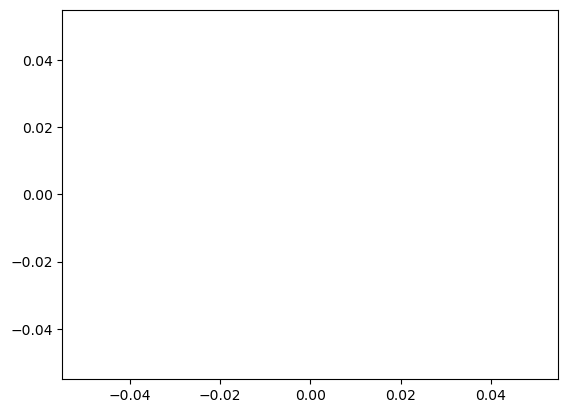

In [ ]:
plt.plot()

In [ ]:
newis = []
for i in [x.detach().numpy() for x in losses]:
    if i > 0.1:
        pass
    else:
        newis.append(i)


In [ ]:

plt.plot([x.detach().numpy() for x in losses],)

In [ ]:
import torch
import torch.nn as nn

# Define the model
class MLP(nn.Module):
  def __init__(self, input_size1, input_size2, hidden_size, output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size1 + input_size2, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x1, x2):
    # Concatenate the inputs
    x = torch.cat((x1, x2), dim=1)
    # Pass the concatenated inputs through the model
    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)
    return x

# Create an instance of the model
model = MLP(input_size1=10, input_size2=5, hidden_size=20, output_size=1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
for epoch in range(100):
  # Generate some fake data for training
  input1 = torch.randn(64, 10)
  input2 = torch.randn(64, 5)
  target = torch.randn(64, 1)

  # Forward pass
  output = model(input1, input2)
  loss = criterion(output, target)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [ ]:
wModel = Model(len(w[0].flatten()), 100, 1)
opt = Optimizer(wModel.parameters())
loss_func = nn.MSELoss()

In [ ]:
from torch.utils.data import DataLoader

bs = 1

tr_dataloader = DataLoader(tr_ds, batch_size=bs, shuffle=True)
te_dataloader = DataLoader(te_ds, batch_size=bs, shuffle=True)

In [ ]:
y,g,w = next(iter(tr_dataloader))

In [ ]:
y,g,w

(tensor([-0.0800], dtype=torch.float64),
 tensor([[-0.0150, -0.0167, -0.0021, -0.0018,  0.0007,  0.0036,  0.0149,  0.0025,
          -0.0002,  0.0019, -0.0142, -0.0090,  0.0013,  0.0047,  0.0115,  0.0025,
           0.0115, -0.0171, -0.0071, -0.0088]], dtype=torch.float64),
 tensor([[[-1.1368, -1.2739,  0.0493,  ...,  0.3897, -0.4923, -0.4141],
          [-0.9380, -0.8706, -0.0432,  ...,  0.3897, -1.3578,  0.3211],
          [-1.1977, -1.5086,  0.0691,  ...,  0.3897, -0.9535, -0.4141],
          ...,
          [-1.3843, -1.9836,  0.3795,  ..., -0.2364, -1.3541,  0.1604],
          [-1.5080, -2.6762,  0.5380,  ..., -0.2364, -0.8170, -0.3807],
          [-1.5323, -2.8487,  0.7625,  ..., -0.2364, -0.0700, -0.4095]]],
        dtype=torch.float64))

In [ ]:
wModel = Model(len(w[0].flatten()), 2, 1)
opt = Optimizer(wModel.parameters())
loss_func = nn.MSELoss()
losses = []
for _ in range(1000):
    y,g,w = next(iter(tr_dataloader))
    xb = w.flatten().type(torch.float32)
    preds = wModel(xb)
    loss = loss_func(preds, y.type(torch.float32))
    losses.append(loss.detach().numpy())
    loss.backward()
    with torch.no_grad():
        for l in wModel.layers:
            if hasattr(l, 'weight'):
                l.weight -= l.weight.grad * lr
                l.bias   -= l.bias.grad   * lr
                l.weight.grad.zero_()
                l.bias  .grad.zero_()

In [ ]:
def f():
    yield from losses
    
from itertools import islice

In [ ]:
x = f()

In [ ]:
list(islice(x,5))

[array(0.60116553, dtype=float32),
 array(0.28334367, dtype=float32),
 array(38.599186, dtype=float32),
 array(0.14587544, dtype=float32),
 array(0.12108066, dtype=float32)]

array(0.7243655, dtype=float32)

[<matplotlib.lines.Line2D>]

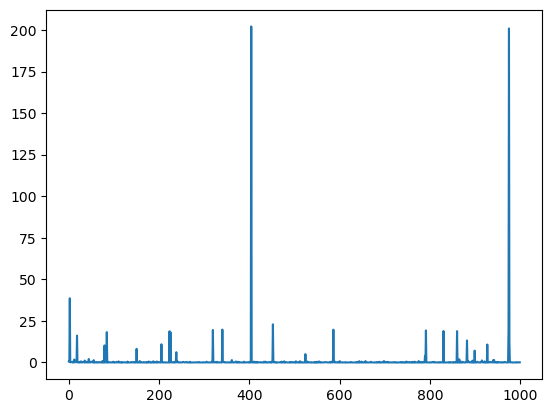

In [ ]:
plt.plot(losses)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.39it/s]


[<matplotlib.lines.Line2D>]

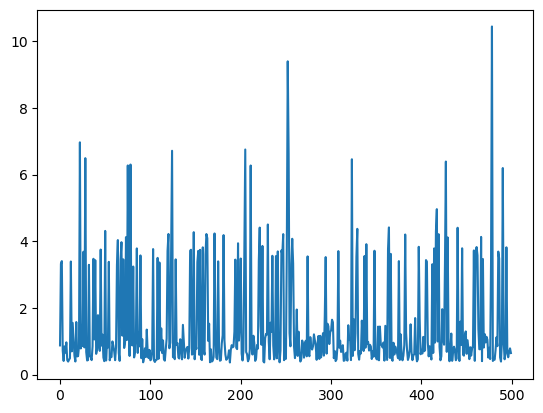

In [ ]:
wModel = Model(len(w[0].flatten()), 2, 1)
opt = Optimizer(wModel.parameters())
loss_func = nn.MSELoss()

losses = []
for epoch in range(5):
    for batch in tqdm(range(100)):
        y,g,w = next(iter(tr_dataloader))
        weather_input = w.reshape(bs,w.shape[1]*w.shape[2]).type(torch.float32)
        predict = wModel(weather_input)
        loss = loss_func(y.type(torch.float32),predict.squeeze().type(torch.float32))
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(loss)

plt.plot([x.detach().numpy() for x in losses])

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.53it/s]


[<matplotlib.lines.Line2D>]

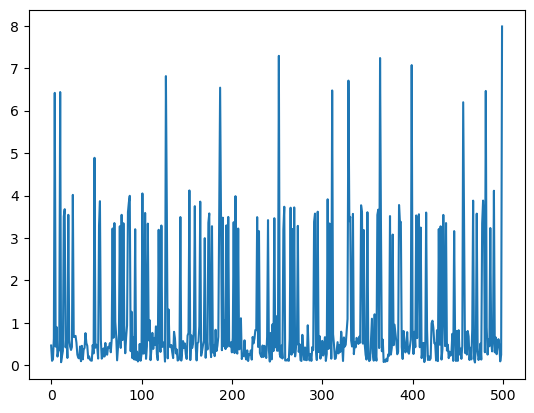

In [ ]:
gModel = Model(len(g[0].flatten()), 50, 1)
opt = Optimizer(gModel.parameters())
loss_func = nn.MSELoss()

losses = []
for epoch in range(5):
    for batch in tqdm(range(100)):
        y,g,w = next(iter(tr_dataloader))
        g_input = g.reshape(bs,g.shape[1]).type(torch.float32)
        predict = wModel(weather_input)
        loss = loss_func(y.type(torch.float32),predict.squeeze().type(torch.float32))
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(loss)

plt.plot([x.detach().numpy() for x in losses])

In [ ]:
y,g,w = next(iter(tr_dataloader))
weather_input = w.reshape(bs,w.shape[1]*w.shape[2]).type(torch.float32)
predict = wModel(weather_input)
loss = loss_func(y.type(torch.float32),predict.type(torch.float32))
loss.backward()
opt.step()
opt.zero_grad()
losses.append(loss)

In [ ]:
y.shape

torch.Size([64])

In [ ]:
.shape

torch.Size([64])

[<matplotlib.lines.Line2D>]

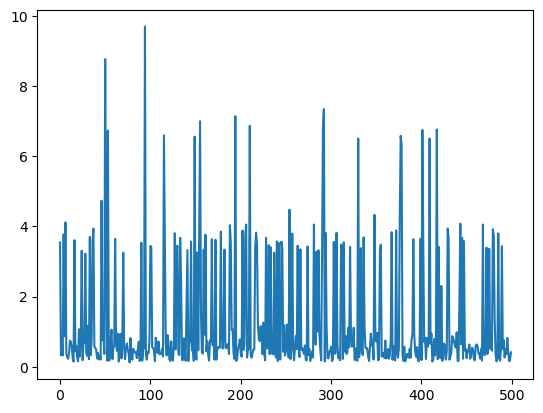

In [ ]:

y.shape

torch.Size([64])

In [ ]:
g.shape

torch.Size([64, 20])

In [ ]:
w.shape

torch.Size([64, 365, 16])

64

In [ ]:
wModel = Model(len(w[0].flatten()), 100, 1)

In [ ]:
w.shape

torch.Size([2, 365, 16])

In [ ]:
weather_input = w.reshape(2,w.shape[1]*w.shape[2]).type(torch.float32)

In [ ]:
pred = wModel(weather_input)

In [ ]:
loss(pred,y)

tensor(0.0688, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [ ]:
for target, inp in next(iter(tr_dataloader)):
    pass

In [ ]:
target.shape

torch.Size([365, 16])

In [ ]:
inp.shape

torch.Size([365, 16])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()